In [1]:
%cd ../src

/Users/mikhail_zybin/food-order-chat-bot/src


In [2]:
import evaluator
from pathlib import Path
import seaborn as sns

In [3]:
factual_correctness_list = []
appropriateness_list = []
for i in range(1, 14):
    factual_correctness, appropriateness = evaluator.evaluate_scenario(i)
    factual_correctness_list.append(factual_correctness)
    appropriateness_list.append(appropriateness)

2024-12-06 15:32:24.946 | INFO     | evaluator:evaluate_scenario:60 - Evaluating scenario 1
2024-12-06 15:32:34.360 | INFO     | evaluator:evaluate_scenario:79 - --------------------predicted_message--------------------
2024-12-06 15:32:34.363 | INFO     | evaluator:evaluate_scenario:80 - Pasta sounds delicious! There are a few restaurants that serve pasta. Based on your choice, I would recommend checking out Roman Holiday, which serves traditional Italian dishes, including pasta.

Would you like to order from Roman Holiday?
2024-12-06 15:32:34.365 | INFO     | evaluator:evaluate_scenario:81 - --------------------ground_truth--------------------
2024-12-06 15:32:34.373 | INFO     | evaluator:evaluate_scenario:82 - Pasta is a great choice. Based on your preference, I would recommend the following restaurants that serve pasta:
1. Roman Holiday (Italian restaurant)
2. Sukhothai (Thai restaurant, they have a dish called Pad See Ew which is a stir-fried wide rice noodles with broccoli, egg,

Your order of 10 portions of Khinkali, 3 portions of Churchkhela from Gagimarjos was successfully received and will be delivered to you by 12:00


2024-12-06 15:42:41.748 | INFO     | evaluator:evaluate_scenario:95 - {'factual_correctness': 1.0, 'factual_correctness_explanation': "The chatbot correctly identified the user's order as Khinkali and Churchkhela from Gagimarjos, and also correctly stated the delivery time as 12:00. The information is available in the chatbot's data.", 'appropriateness': 1.0, 'appropriateness_explanation': "The chatbot's response is highly relevant to the user's order. It confirms the order and asks for confirmation, which is a standard practice in food ordering. The chatbot's response is also concise and easy to understand."}
2024-12-06 15:42:49.636 | INFO     | evaluator:evaluate_scenario:79 - --------------------predicted_message--------------------
2024-12-06 15:42:49.638 | INFO     | evaluator:evaluate_scenario:80 - You have chosen to order 10 portions of Khinkali, 3 portions of Churchkhela, 1 portion of Lobio from Gagimarjos by 12:00. Is that correct?
2024-12-06 15:42:49.641 | INFO     | evaluato

Your order of 10 portions of Khinkali, 3 portions of Churchkhela, 1 portion of Lobio from Gagimarjos was successfully received and will be delivered to you by 12:00


2024-12-06 15:43:00.056 | INFO     | evaluator:evaluate_scenario:95 - {'factual_correctness': 0.0, 'factual_correctness_explanation': 'The chatbot incorrectly stated that the user chose to order Khinkali, Churchkhela, and Lobio from Gagimarjos by 12:00. The user actually removed Khinkali and added Lobio, so the correct order is Churchkhela and Lobio.', 'appropriateness': 0.0, 'appropriateness_explanation': "The chatbot did not take into account the user's request to remove Khinkali and add Lobio, and instead repeated the incorrect order. The chatbot should have acknowledged the user's changes and provided the correct order."}
2024-12-06 15:43:00.103 | INFO     | evaluator:evaluate_scenario:60 - Evaluating scenario 7
2024-12-06 15:43:12.056 | INFO     | evaluator:evaluate_scenario:79 - --------------------predicted_message--------------------
2024-12-06 15:43:12.058 | INFO     | evaluator:evaluate_scenario:80 - A hearty dinner with a lot of meat sounds delicious!

To suggest some restau

Your order of 2 portions of Classic Cheeseburger from Burger Shef was successfully received and will be delivered to you by 3 pm today


2024-12-06 15:51:26.916 | INFO     | evaluator:evaluate_scenario:95 - {'factual_correctness': 1.0, 'factual_correctness_explanation': "The chatbot's response correctly reflects the user's order of 2 portions of Classic Cheeseburger from Burger Shef by 3 pm today.", 'appropriateness': 1.0, 'appropriateness_explanation': "The chatbot directly responds to the user's change of mind and asks for confirmation of the new order, making it an appropriate response."}
2024-12-06 15:51:26.951 | INFO     | evaluator:evaluate_scenario:60 - Evaluating scenario 11
2024-12-06 15:51:33.717 | INFO     | evaluator:evaluate_scenario:79 - --------------------predicted_message--------------------
2024-12-06 15:51:33.721 | INFO     | evaluator:evaluate_scenario:80 - You have chosen to order 3 portions of Classic Cheeseburger from Burger Shef by 3 pm today. Is that correct?
2024-12-06 15:51:33.722 | INFO     | evaluator:evaluate_scenario:81 - --------------------ground_truth--------------------
2024-12-06 15:5

Your order of 3 portions of Margherita Pizza from Roman Holiday was successfully received and will be delivered to you by 6 pm today


2024-12-06 15:55:34.186 | INFO     | evaluator:evaluate_scenario:95 - {'factual_correctness': 1.0, 'factual_correctness_explanation': "The chatbot response is factually correct as it accurately reflects the user's order and the restaurant's menu. The chatbot correctly identified the user's choice of 3 Margherita Pizzas from Roman Holiday and the available pizza size option.", 'appropriateness': 1.0, 'appropriateness_explanation': "The chatbot response is appropriate as it directly addresses the user's question about delivery time and confirms the order. The chatbot also provides a clear and concise summary of the user's choice, making it easy for the user to confirm or correct the order."}


In [4]:
factual_correctness_list, appropriateness_list

([0.5875,
  0.8333333333333334,
  0.5333333333333333,
  0.8500000000000001,
  0.96,
  0.65,
  0.7250000000000001,
  0.9,
  0.8400000000000001,
  1.0,
  1.0,
  0.8333333333333334,
  0.7333333333333334],
 [0.42500000000000004,
  0.6333333333333333,
  0.5333333333333333,
  0.7,
  0.8400000000000001,
  0.675,
  0.6,
  0.7333333333333333,
  0.64,
  1.0,
  1.0,
  0.5,
  0.5333333333333333])

<Axes: >

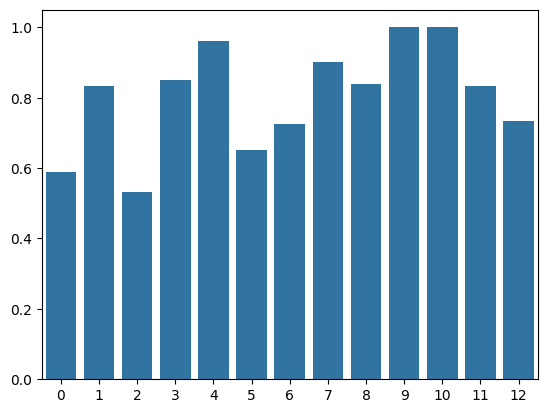

In [5]:
sns.barplot(factual_correctness_list)